### Задача

Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента.  
Сформировать типичные портреты пользователей.  
Проанализировать основные признаки, наиболее сильно влияющие на отток.  
Сформулировать основные выводы и предложить рекомендации для стратегии взаимодействия с пользователями и их удержания. 

### Оглавление

[1. Открытие и изучение данных](#1)  
[2. Исследовательский анализ данных](#2)  
[3. Модель прогнозирования оттока пользователей](#3)  
[4. Кластеризация пользователей](#4)  
[5. Общий вывод](#5)

### Импорт библиотек и настройки

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

### 1. Открытие и изучение данных <a id='1'></a>

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv', sep=',')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В датасете 4000 строк и 14 колонок, пропусков нет, категориальных переменных нет.

### 2. Исследовательский анализ данных <a id='2'></a>

Изучим основные параметры выборки

In [4]:
for i in df.columns:
    print(i)
    print(df[i].describe())

gender
count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
Near_Location
count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Near_Location, dtype: float64
Partner
count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Partner, dtype: float64
Promo_friends
count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Promo_friends, dtype: float64
Phone
count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
m

Сразу отметим, что явных выбросов нет.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [5]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


По многим показателям значения ушедших меньше: клиенты младше, они выбирают короткие абонементы, реже ходят в зал и посещают групповые программы, меньше тратят на доп. услуги. 

Напишем функцию для визуализации распределений.

In [6]:
def hist_differences(data, column, labels=None):
    fig = plt.figure(figsize=(25, 30))
    
    unique_values = data[column].unique()
    
    fig.suptitle('Гистограммы', y=0.92, fontsize=22) 
    
    for i, el in enumerate(data.columns.drop(column)):
        ax = fig.add_subplot(5,3,i + 1)
        
        for val in unique_values:    
            sns.distplot(
                df[df[column] == val][el],
                label=val,
                kde=False,
                ax=ax
            )   
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    if labels: 
        ax_labels = (labels[el] for el in ax_labels)
    handles = {label: handle for handle, label in zip(ax_handles, ax_labels)}

    fig.legend(
        handles.values(), 
        handles.keys(), 
        ncol=len(unique_values), 
        loc = 'upper center', 
        bbox_to_anchor=(0.4, 0.8), 
        prop={'size': 17}
    )
    plt.show()

Построим столбчатые гистограммы для тех, кто остался, и тех, кто попал в отток.

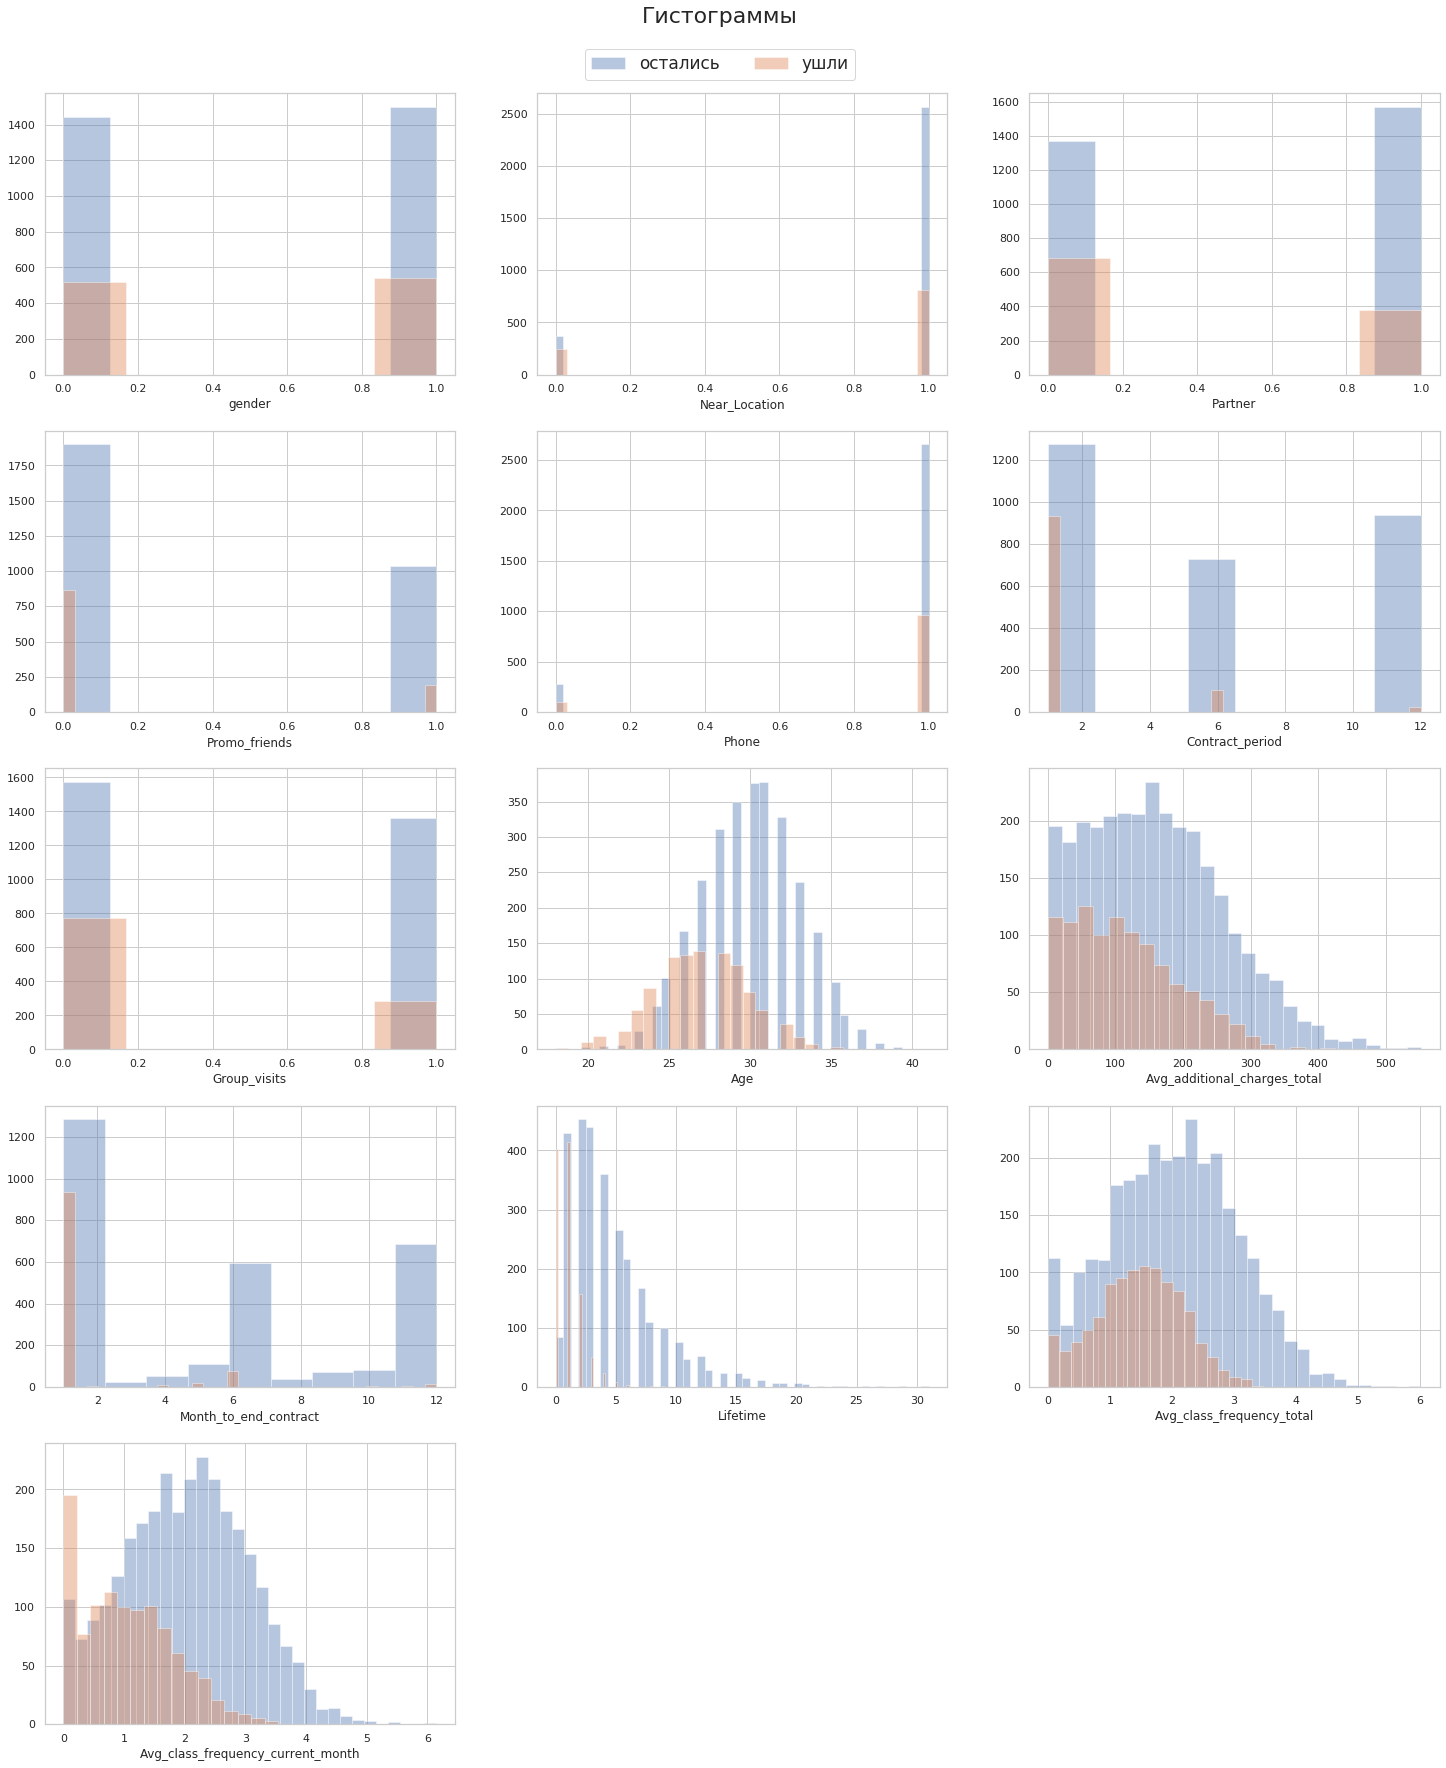

In [7]:
hist_differences(df, 'Churn', {'0': 'остались', '1': 'ушли'})

`gender` - по этому признаку деление довольно равномерное и пропорциональное.  
`Near_Location` - большинство клиентов живут недалеко, среди тех, кто живет далеко, клиентов ушло больше.  
`Partner` - среди тех, кто не участвует в партнерской программе, ушедших больше.  
`Promo_friends` - среди тех, кто пришел один, ушедших больше.  
`Phone` - в отток попадают как те, кто оставил свой номер телефон, так и те, кто не оставил.   
`Contract_period` - большой отток наблюдается у тех, кто оформил абонемент на месяц.  
`Group_visits` - клиенты, которые не посещают групповые программы, уходят чаще.  
`Age` - самый часто встречаемый возраст оставшихся- около 30, ушедших - около 27.   
`Avg_additional_charges_total` - суммарная выручка от других услуг оставшихся клиентов (до 400) больше, чем ушедших (до 300).     
`Month_to_end_contract` - часто встречаемые значения совпадают с длительностью покупаемых абонементов,  
`Lifetime` - время использования зала ушедших значительно меньше, в основном 0-1 мес.  
`Avg_class_frequency_total` - клиенты, попадающие в отток, реже ходят в зал.    
`Avg_class_frequency_current_month` - многие ушедшие не сообщили о своем решении и просто не ходили в зал последний месяц, но есть и те, кто ходил в последний месяц на занятия, хотя и реже чем основная масса оставшихся. 

Построим матрицу корреляций. 

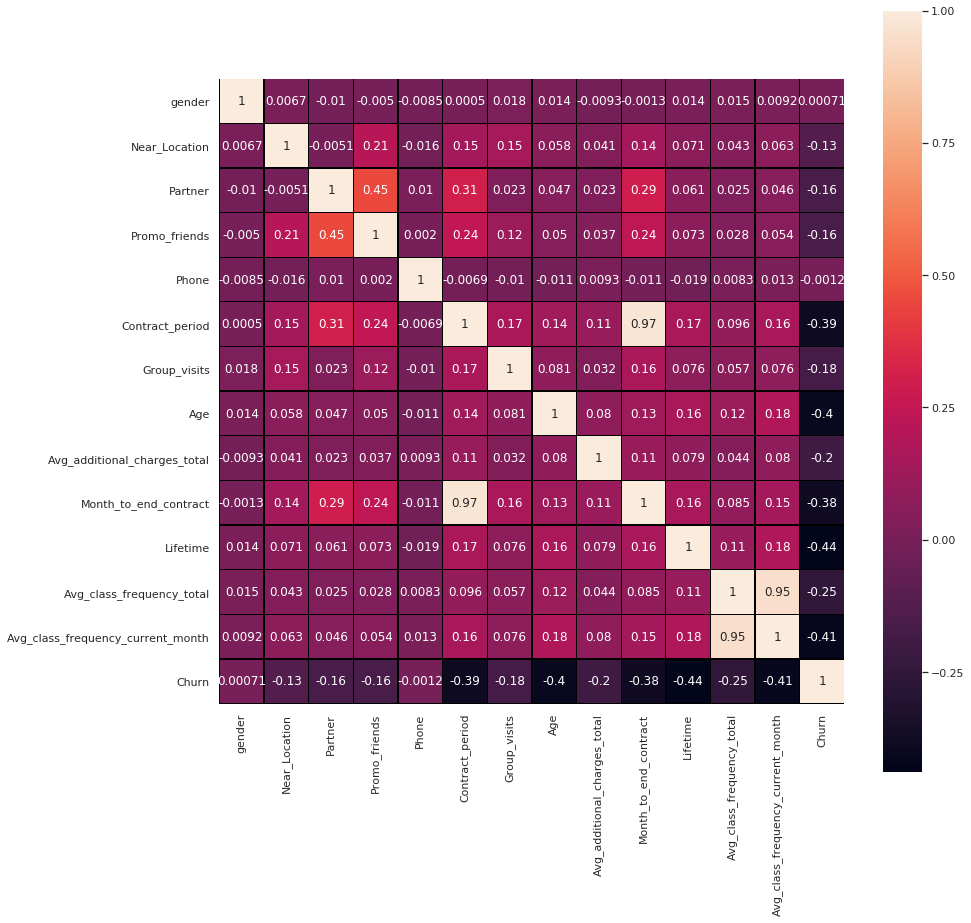

In [8]:
fig = plt.figure(figsize=(14, 14))
sns.heatmap(df.corr(), annot=True, square=True, linewidths=0.3, linecolor='black')

Высокая корреляция отмечается у параметров `Contract_period` - `Month_to_end_contract` (большинство клиентов недавно приобрело абонементы)
и `Avg_class_frequency_total` - `Avg_class_frequency_current_month` (частота в последний месяц посещений остается почти такой же, как и обычно).

После проведения EDA можно выделить следующее: если клиент живёт далеко, не участвует в партнерской или "дружеской" программе, не посещает групповые программы, оформляет абонемент на месяц или редко посещает зал, то он с большей вероятностью уйдёт в отток.

### 3. Модель прогнозирования оттока пользователей <a id='3'></a>

У нас есть как параметры, так и целевая переменная поэтому будем использовать обучение с учителем, а именно бинарную классификацию, так как в результате мы должны получить либо 0 класс (клиент останется), либо 1 класс (клиент уйдет).

Чтобы подобрать лучший вариант, сравним несколько возможных моделей. Для обучения будем использовать логистическую регрессию и случайный лес.

In [9]:
models = [LogisticRegression, RandomForestClassifier]

Разобьем данные на обучающую и валидационную выборку.

In [10]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Напишем функцию для работы с моделью.

In [12]:
def learn_model(m, X_train, X_test, y_train, y_test):
        
    # обучение модели
    model = m(random_state=0)
    model.fit(X_train, y_train)
    
    # проверка модели на тестовой выборке
    prediction = model.predict(X_test)
    
    # расчёт основных метрик
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test ,prediction)))
    print('Precision: {:.2f}'.format(precision_score(y_test ,prediction)))
    print('Recall: {:.2f}'.format(recall_score(y_test ,prediction)))

Оценим работу моделей.

In [13]:
for i in models:
    print(i)
    learn_model(i, X_train, X_test, y_train, y_test)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy: 0.93
Precision: 0.86
Recall: 0.83
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Accuracy: 0.91
Precision: 0.83
Recall: 0.78


Модель, обученная с помощью случайного леса, показала результаты лучше. Доля правильных ответов (accuracy), точность (precision) и полнота (recall) у нее выше.

### 4. Кластеризация пользователей <a id='4'></a>

Тип задачи в данном случае - обучение без учителя. Модель сама выделит нужное количество кластеров (в качестве результата нужно получить 5 кластеров). Для это воспользуемся алгоритмом K-Means.

Привести признаки к единому масштабу с помощью стандартизации.

In [14]:
sc = StandardScaler()
X_sc = sc.fit_transform(df)

Нарисуем дендрограмму.

In [15]:
linked = linkage(X_sc, method = 'ward')

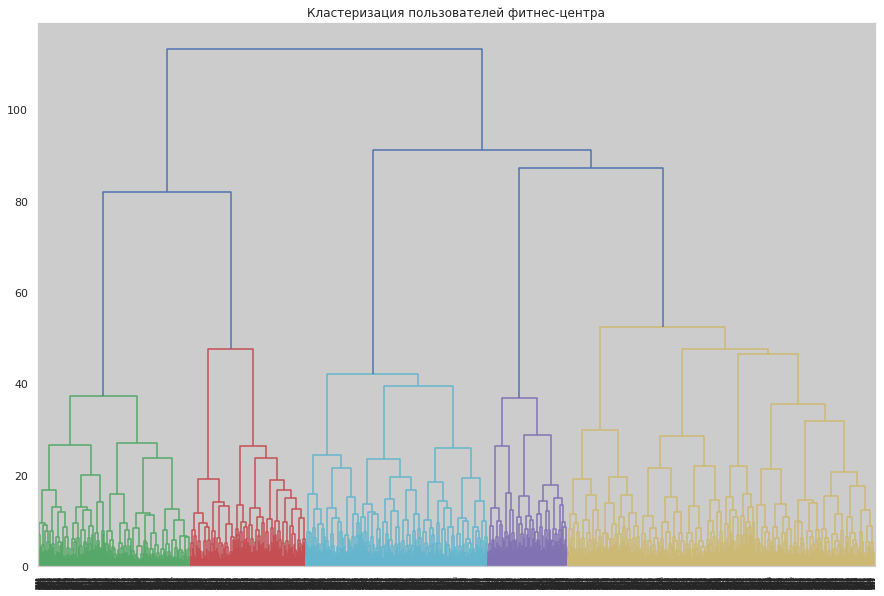

In [16]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей фитнес-центра')
plt.show()

Предложенное оптимальное число кластеров - 5 (по цветам на графике).

Создадим и обучим модель.

In [17]:
model = KMeans(n_clusters=5)
labels = model.fit_predict(X_sc)

Сохраним кластеры в датафрейм и выведем средние значения для каждого кластера.

In [18]:
df['cluster'] = labels
df.drop('Churn', axis=1).groupby('cluster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster,,,,,,,,,,,,,
0,0.546929,0.844728,0.367323,0.209733,0.998841,2.676709,0.436848,29.988413,160.879827,2.469293,4.600232,2.904467,2.912142
1,0.477193,0.824561,0.459649,0.264327,1.000000,2.761404,0.385965,30.028070,151.348090,2.552047,4.688889,1.157304,1.155556
2,0.526178,0.869110,0.471204,0.308901,0.000000,4.816754,0.429319,29.340314,144.517762,4.502618,3.955497,1.857525,1.727260
3,0.503650,0.938478,0.767466,0.563087,1.000000,11.199166,0.558916,29.880083,162.792871,10.254432,4.683003,2.031016,2.025194
4,0.506908,0.759830,0.341126,0.179596,0.996812,1.566419,0.257173,26.907545,114.993470,1.513284,0.975558,1.448150,1.025562


В 0 группе клиенты покупают самые короткие абонементы, редко ходят в зал, на групповые тренировки.  
В 1 группе клиенты покупают самые длительные абонементы, чаще всех ходят на групповые тренировки, приходят по партнерской или "дружеской" программе.  
Во 2 кластере находятся те, кто живет далеко, из них меньшинство ходит на групповые программы.  
В 3 кластере больше всех тратят на доп. услуги, дольше и чаще всех ходят в зал.  
В 4 кластере не оставляют свой номер телефона, чаще оформляют абонемент на длительный срок.  

Построим гистограммы параметров по кластерам.

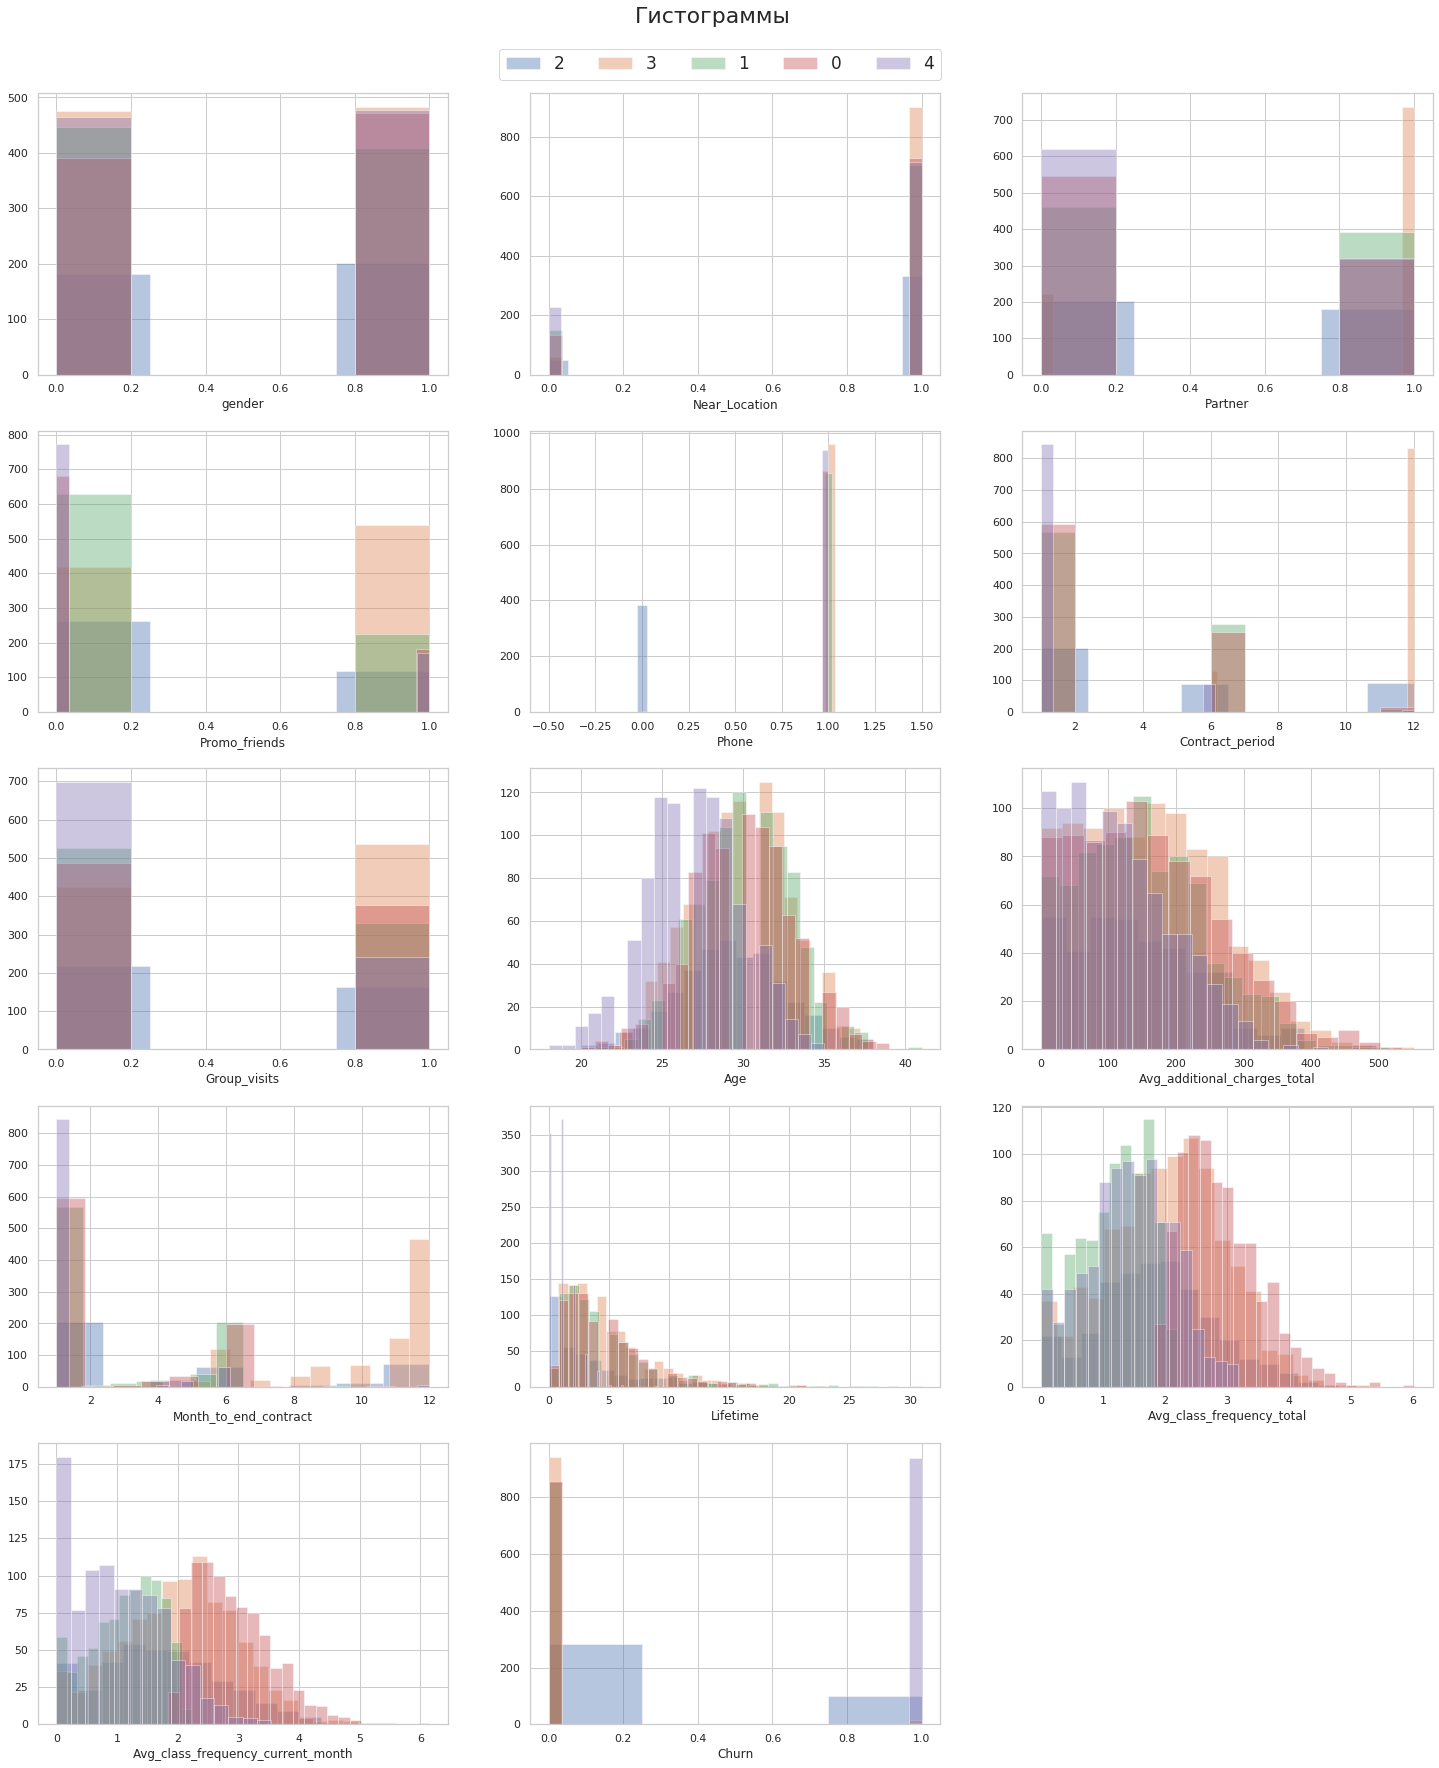

In [19]:
hist_differences(df, 'cluster')

1 и 3 кластер выделяются, численность в них больше. На распределениях по многим показателям их значения смещены вправо: клиенты старше, чаще и дольше ходят в зал, чаще посещают групповые программы, больше тратят на доп. услуги. 

Посчитаем долю оттока для каждого кластера.

In [20]:
df.groupby('cluster')['Churn'].mean().reset_index()

,cluster,Churn
0,0,0.006952
1,1,0.001170
2,2,0.261780
3,3,0.015641
4,4,0.997875


Кластер 0 состоит из клиентов, склонных к оттоку (92%). А в 1 и 3 кластере почти 100% оставшихся клиентов.

### 5. Общий вывод <a id='5'></a>

Модель прогнозирования оттока пользователей, обученная с помощью случайного леса, показала результаты лучше. Доля правильных ответов (accuracy), точность (precision) и полнота (recall) у нее выше.  

По имеющимся данным выполнено деление на 5 кластеров: где кластер 0 состоит из клиентов, склонных к оттоку (92%). А в 1 и 3 кластере почти 100% оставшихся клиентов. 

1 и 3 кластер отличаются более высокими показателями: клиенты старше, чаще и дольше ходят в зал, чаще посещают групповые программы, больше тратят на доп. услуги. 
В 0 кластер наоборот показатели низкие.  

Часть клиентов (0 кластер) оформляют пробный абонемент на месяц, но не остаются. Ходят в среднем 1 раз в неделю, не успевают привыкнуть. Таких клиентов необходимо мотивировать чаще и дольше ходить в зал.  
1. Можно запустить выгодное предложение о покупке абонементов на 2 или 3 месяца для новых клиентов, что даст новым клиентам больше времени на адаптацию.  
2. Посещение групповых программ тоже важный показатель, который привлекает новых клиентов, так как с ними занимается тренер. Чтобы замотивировать новых клиентов ходить чаще, можно сделать специальные классы для "новичков". Тогда клиенты не будут стесняться своих навыков, им будет проще найти единомышленников и остаться. 